### **building CNN model fom image classification based on the cifar10 and cifar100 databases:**

In [ ]:
import numpy as np
import pandas as pd
import joblib
from PIL import Image
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

from __future__ import print_function


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline


import os
import json
import time
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# %matplotlib inline
# np.set_printoptions(precision=7)
# %load_ext autoreload
# %autoreload 2



first we need to decide on our hyper parameters

In [ ]:
batch_size = 100  # The default batch size of keras.
epochs = 400
data_augmentation = True
num_classes=15
#give path to where the data is stored- github/google drive
data="/content/drive/MyDrive/cfar10_modified_100.npz"

In [ ]:
#function to load data from the google drive
def read_data_from_drive():
  #if data is stored in google drive the next two lines will be nessacary
  from google.colab import drive
  drive.mount('/content/drive')
  data_dict=np.load(data)
  return data_dict

In [ ]:
#separate data to train, test and validation
def separate_data(data_dict):
  x_train=data_dict['train']
  y_train=data_dict['ytrain']
  x_test=data_dict['test']
  y_test=data_dict['ytest']
  x_validation=data_dict['validation']
  y_validation=data_dict['yvalidation']

  return  x_train, y_train,x_test,y_test,x_validation,y_validation
  
  
  
  

In [ ]:
#prepare the data for the model - load separate and one hot(on Y)
def prepare_for_model():
  data_dict=read_data_from_drive()
  x_train, y_train,x_test,y_test,x_validation,y_validation=separate_data(data_dict)

  y_train = y_train.astype(np.int16)
  y_test = y_test.astype(np.int16)
  y_validation = y_validation.astype(np.int16)

  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  y_validation = keras.utils.to_categorical(y_validation, num_classes)

  print('x train shape:',x_train.shape)
  print('x_test shape:',x_test.shape)
  print('x_validation shape:',x_validation.shape)

  print('y train shape:',y_train.shape)
  print('y_test shape:',y_test.shape)
  print('y_validation shape:',y_validation.shape)
  return  x_train, y_train,x_test,y_test,x_validation,y_validation


were gonna call the prepare_for_model func to load all the data,
after this the data will be ready to run on the model

In [ ]:
  x_train, y_train,x_test,y_test,x_validation,y_validation=prepare_for_model()


Mounted at /content/drive
x train shape: (52275, 32, 32, 3)
x_test shape: (11250, 32, 32, 3)
x_validation shape: (11475, 32, 32, 3)
y train shape: (52275, 15)
y_test shape: (11250, 15)
y_validation shape: (11475, 15)


In [ ]:
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model = define_model1()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
    
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Using real-time data augmentation.
Epoch 1/400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


523/523 [==============================] - 46s 61ms/step - loss: 2.6673 - accuracy: 0.2292 - val_loss: 1.9429 - val_accuracy: 0.3581
Epoch 2/400
523/523 [==============================] - 34s 64ms/step - loss: 2.0934 - accuracy: 0.3225 - val_loss: 1.8562 - val_accuracy: 0.3775
Epoch 3/400
523/523 [==============================] - 32s 62ms/step - loss: 1.9072 - accuracy: 0.3686 - val_loss: 1.8091 - val_accuracy: 0.3853
Epoch 4/400
523/523 [==============================] - 31s 59ms/step - loss: 1.7917 - accuracy: 0.4002 - val_loss: 1.7477 - val_accuracy: 0.4116
Epoch 5/400
523/523 [==============================] - 31s 59ms/step - loss: 1.7221 - accuracy: 0.4224 - val_loss: 1.6643 - val_accuracy: 0.4306
Epoch 6/400
523/523 [==============================] - 31s 58ms/step - loss: 1.6593 - accuracy: 0.4437 - val_loss: 1.7288 - val_accuracy: 0.4204
Epoch 7/400
523/523 [==============================] - 32s 60ms/step - loss: 1.6113 - accuracy: 0.4612 - val_loss: 1.6440 - val_accuracy: 0.44

plot history of model accuracy for every epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


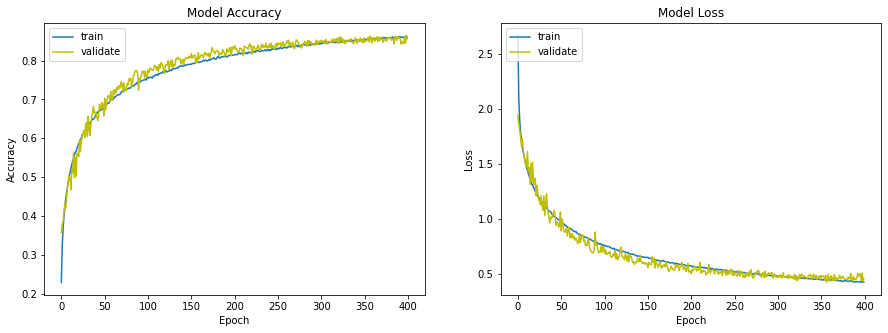

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy'],'y') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss'],'y') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

352/352 [==============================] - 1s 4ms/step - loss: 0.4563 - accuracy: 0.8564
Test loss: 0.45632466673851013
Test accuracy: 0.8563555479049683


save model and model history:

In [ ]:
#give path of where you wanna store the data- github/google drive

save_dir =  '/content/drive/MyDrive/saved_models'
model_name = 'keras_cifar10_trained_model_15_classes.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /content/drive/MyDrive/saved_models/keras_cifar10_trained_model_15_classes.h5 


In [ ]:
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/saved_models/history_15_classes.csv')
